In [8]:
from model import atp_graph, losses
from data_wrangler import synthetic_data_gen, feature_extractor
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline
from comparison_models.tnp import tnp_pipeline
from data_wrangler import dataset_preparer
import argparse
from data_wrangler.batcher import batcher, batcher_np
import os
import matplotlib.pyplot as plt
import numpy as np

In [9]:
dataset = "exchange"
model = "atp"
iterations = 300
num_repeats = 1
n_C = 96
n_T = 336

In [10]:


if dataset == "exchange":
    x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor(path_to_data="datasets/exchange.csv") 
    save_dir = "weights/forecasting/exchange"
    print('make sure to create the exchange folder in weights/forecasting/')
else: 
    raise ValueError("Dataset not found")
    
save_dir = save_dir + "/" + model

    
batch_size = 32
test_batch_s = 100

nll_list = []
mse_list = []




   



make sure to create the exchange folder in weights/forecasting/


In [11]:
save_dir = "weights/dummy"

In [5]:
x_train, y_train, x_val, y_val, x_test, y_test,_ = dataset_preparer.gp_data_processor(path_to_data_folder="datasets/rbf/") 


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/rbf/x.npy'

# TNP


In [ ]:
i = 0
step = 1
run= 50 + i
tf.random.set_seed(run)


In [ ]:

model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=8,output_shape=48, dropout_rate=0.1, 
                 permutation_repeats=0,bound_std=False, num_layers=6,target_y_dim=1)

Model 1

model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=16,output_shape=32, dropout_rate=0.0, 
                 permutation_repeats=1,bound_std=False, num_layers=6,target_y_dim=1)
                 
Best val score:  0.12        

Model 2 

model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=16,output_shape=32, dropout_rate=0.2, 
                 permutation_repeats=1,bound_std=False, num_layers=6,target_y_dim=1)
                 
Best val score: 0.11



Modle 4
model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=8,output_shape=48, dropout_rate=0.05, 
                 permutation_repeats=1,bound_std=False, num_layers=6,target_y_dim=1)
     
     
0.099




Model 7


model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=12,output_shape=16, dropout_rate=0.1, 
                 permutation_repeats=1,bound_std=False, num_layers=6,target_y_dim=1)
                 
                 
0.22            

Model 8

model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=12,output_shape=16, dropout_rate=0.25, 
                 permutation_repeats=1,bound_std=False, num_layers=6,target_y_dim=1)
                 
0.04    

Model 9 

model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=8,output_shape=48, dropout_rate=0.05, 
                 permutation_repeats=0,bound_std=False, num_layers=6,target_y_dim=1)


-0.6

Model 10 


model = tnp_pipeline.tnp_pipeline(num_heads=6,projection_shape_for_head=12,output_shape=16, dropout_rate=0.15, 
                 permutation_repeats=0,bound_std=False, num_layers=6,target_y_dim=1)
                 
Use model 9

In [ ]:
n_T = 720

In [ ]:
array = []
train_array = []

In [ ]:
idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T,batch_s=32)

In [ ]:
μ, log_σ = model([x, y, n_C, n_T, False])


In [ ]:
μ.shape

In [ ]:
model.summary()

In [ ]:

    run = 54
    tr_step = atp_graph.build_graph()

    ###### can we put the name of the model into the folder name #########?

    name_comp = 'run_' + str(run)
    folder = save_dir + '/ckpt/check_' + name_comp
    if not os.path.exists(folder): os.mkdir(folder)
    opt = tf.keras.optimizers.Adam(3e-4)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
    ckpt.restore(manager.latest_checkpoint) 
    sum_mse_tot = 0; sum_nll_tot = 0
    mini = 50000

In [ ]:
for i in range(2000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    _,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not just forecasting
    x = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=32)
    #### edit batcher to fix this
    _,_, nll_pp_tr, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        train_array.append(nll_pp_tr)
        idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
        _,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=100)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        array.append(nll_pp_te)
        
        plt.plot(train_array)
        plt.plot(array)
        plt.show()

        print(nll_pp_te)
        print(min(array))

        if nll_pp_te < mini:
            mini = nll_pp_te
            manager.save()
            step += 1
            ckpt.step.assign_add(1)




In [ ]:
ckpt = tf.train.Checkpoint(step=tf.Variable(step), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [ ]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))

t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)


In [ ]:
nll_pp_te

In [ ]:
plt.plot(y_te[1,:,:])

In [ ]:
sum_mse_tot = 0; sum_nll_tot = 0

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = len(idx_list)//test_batch_s
t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)


In [ ]:
nll_pp_te

In [ ]:
msex_te

In [ ]:
test_batch_s

In [ ]:
y_mean = np.mean(y_te[:,:96],axis=1)

In [ ]:
y_mean_repeat = np.repeat(y_mean[:,np.newaxis,:],axis=1,repeats=96)

In [ ]:
np.mean((y_te[:,96:] - y_mean_repeat)**2)

In [ ]:
test_batch_s = 100

sum_mse_tot = 0; sum_nll_tot = 0

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = len(idx_list)//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)        
    _,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=y_te.shape[0])
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)

print(msex)

In [ ]:
nllx

In [ ]:
msex

In [ ]:
plt.plot(y_te[4])

In [ ]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
print(sum_nll/n_T/100)

In [ ]:
plt.plot(y_te[4])

In [ ]:
plt.plot(y_test[:,0,0])

In [ ]:
plt.plot(y_val[:,0,0])

In [ ]:
sum_nll/n_T/100

In [ ]:
nllx

In [ ]:
msex

In [ ]:
array = np.load("weights/forecasting/exchange/tnp/ckpt/check_run_2/validation_losses_iteration.npy")

In [ ]:
plt.plot(array)

In [ ]:
np.min(array)

In [ ]:
array = np.load("weights/forecasting/exchange/atp/ckpt/check_run_2/validation_losses_iteration.npy")
plt.plot(array)
np.min(array)

In [ ]:
array = np.load("weights/forecasting/exchange/atp/nll_list.npy")
array
array.mean()

In [ ]:
array = np.load("weights/forecasting/exchange/tnp/nll_list.npy")
array
array.mean()

# atp

In [12]:
i = 0
step = 1
run= 50 + i
tf.random.set_seed(run)


Model 1

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=8, output_shape=32, rate=0.1, permutation_repeats=0,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=2)
                 
-1.3

Model 2

model = atp_pipeline.atp_pipeline(num_heads=7, projection_shape_for_head=15, output_shape=32, rate=0.1, permutation_repeats=0,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=1)
                 
-1.35

Model 3

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=12, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1)

-1.35

Model 4 

model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage=False)
                 
-1.34

Model 5

model = atp_pipeline.atp_pipeline(num_heads=3, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=6, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage=False)
                 
-1.35

Model 6 

model = atp_pipeline.atp_pipeline(num_heads=10, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=6, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="new_block")

-1.33

Model 7

-1.31

Model 8  

model = atp_pipeline.atp_pipeline(num_heads=8, projection_shape_for_head=12, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")

-1.34

In [101]:
# model = atp_pipeline.atp_pipeline(num_heads=8, projection_shape_for_head=12, output_shape=32, rate=0.0,
#                                   permutation_repeats=0,
#                  bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")



# model = atp_pipeline.atp_pipeline(num_heads=10, projection_shape_for_head=9, output_shape=32, rate=0.05, permutation_repeats=0,
#                  bound_std=False, num_layers=6, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="new_block")

array = []
train_array = []

idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T)

μ, log_σ = model([x, y, n_C, n_T, False])


model.summary()

y_values.shape (32, 101, 1)
x_values.shape (32, 101, 1)
(32, 5, 101)
Model: "atp_pipeline_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_wrapper_6 (feature_  multiple                 0         
 wrapper)                                                        
                                                                 
 atp_6 (ATP)                 multiple                  91856     
                                                                 
 de_6 (DE)                   multiple                  4         
                                                                 
Total params: 91,860
Trainable params: 91,858
Non-trainable params: 2
_________________________________________________________________


In [158]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_val,y_val,idx_list,window=n_C+n_T)

μ, log_σ = model([x, y, n_C, n_T, False])

y_values.shape (32, 101, 1)
x_values.shape (32, 101, 1)
(32, 5, 101)


In [ ]:
# # trained model  
# <tf.Tensor: shape=(), dtype=float32, numpy=0.15612265>,
#  <tf.Tensor: shape=(), dtype=float32, numpy=-245.76495>,
#  <tf.Tensor: shape=(), dtype=float32, numpy=-1.536031>,
#  <tf.Tensor: shape=(), dtype=float32, numpy=0.0009757666>)

In [ ]:
# # untrained model
#  <tf.Tensor: shape=(), dtype=float32, numpy=1010.84686>,
#  <tf.Tensor: shape=(), dtype=float32, numpy=24778.16>,
#  <tf.Tensor: shape=(), dtype=float32, numpy=154.86351>,
#  <tf.Tensor: shape=(), dtype=float32, numpy=6.317793>)

In [160]:
model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=11, output_shape=32, rate=0.05, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")  

In [161]:
μ, log_σ = model([x, y, n_C, n_T, False])

y_values.shape (32, 101, 1)
x_values.shape (32, 101, 1)
(32, 5, 101)


In [162]:
losses.nll(y[:, n_C:n_C+n_T], μ, log_σ)

(<tf.Tensor: shape=(32, 5, 1), dtype=float32, numpy=
 array([[[ 41.10784 ],
         [ 43.47036 ],
         [ 40.831615],
         [ 40.823376],
         [ 40.816475]],
 
        [[ 63.84092 ],
         [ 63.936306],
         [ 64.80434 ],
         [ 65.605865],
         [ 64.84183 ]],
 
        [[ 34.206566],
         [ 34.074726],
         [ 34.85317 ],
         [ 34.603077],
         [ 35.271225]],
 
        [[213.94952 ],
         [213.44682 ],
         [213.03703 ],
         [205.17073 ],
         [212.84114 ]],
 
        [[291.7658  ],
         [298.0635  ],
         [293.2483  ],
         [292.20972 ],
         [294.7659  ]],
 
        [[119.5765  ],
         [119.39798 ],
         [116.49311 ],
         [119.326706],
         [117.84418 ]],
 
        [[104.23617 ],
         [105.62626 ],
         [105.48679 ],
         [105.33563 ],
         [106.694145]],
 
        [[ 24.156044],
         [ 25.845425],
         [ 24.211676],
         [ 24.308603],
         [ 25.20354 ]],
 
   

In [ ]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
x,y,_ = batcher(x_val,y_val,idx_list,window=n_C+n_T)

μ, log_σ = model([x, y, n_C, n_T, False])

In [ ]:
def xt_pδ_g_xt(model,x, y, n_C, n_T, μ=[], r=0, sample=True):
    assert x.shape[0] == 1 and y.shape[0] == 1 
    #δ:= number of days in the future
    ## model atp_pipeline or just atp?
    # batch_size = 1



    y_temp = np.concatenate([y, np.zeros((1,1,1))],axis=1)
    μ_tp1, log_σ_tp1  = model([x[:, :y_temp.shape[1], :], y_temp, n_C, 1 +i, False])     
    if sample:
        μ.append(np.random.normal(μ_tp1.numpy()[0, -1, 0], np.exp(log_σ_tp1.numpy()[0, -1, 0])))
    else:
        μ.append(μ_tp1.numpy()[0, -1, 0])
    
    y = np.concatenate([y, μ[-1][np.newaxis, np.newaxis, np.newaxis]], axis=1) 
    if r == n_T-1:
        return μ
    return xt_pδ_g_xt(model, x, y, n_C, n_T, μ,  r+1)

In [134]:
x_1 = x_test[0:192,:,:].transpose(1,0,2)
y_1 = y_test[0:96,:,:].transpose(1,0,2)

In [141]:
y_temp.shape

(10, 116, 1)

(95.0, 116.0)

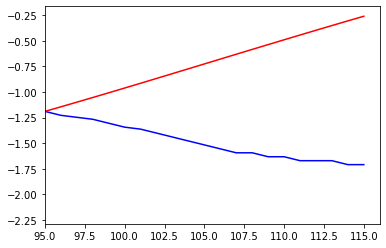

In [154]:
plt.plot(y_test[0:96+20,:,:].transpose(1,0,2).reshape(-1), color="blue")
for i in range(y_temp.shape[0]):
    plt.plot(y_temp[i, :, :].reshape(-1), color="red")
plt.xlim(95, 96+20)

In [135]:
y_1 = y_test[0:96,:,:].transpose(1,0,2)

In [153]:
y_temp = y_1.copy()
x_temp = x_1.copy()
num_samples = 1
y_temp = np.repeat(y_temp, num_samples, axis=0)
x_temp = np.repeat(x_temp, num_samples, axis=0)
μ = []
sample = False
# y_temp = y_1.copy()
for i in range(20):
    y_temp = np.concatenate([y_temp, np.zeros((num_samples, 1, 1))], axis=1)
    
    # print("y_temp step {} values {}".format(i,y_temp[:, 96:, :]))
    μ_tp1, log_σ_tp1  = model([x_temp[:, :y_temp.shape[1], :], y_temp, n_C, 1 + i, False])       # y_tp1 shape is (batch_size, n_T, 1) 
    if sample:
        μ.append(np.random.normal(μ_tp1.numpy()[:, -1, 0], np.exp(log_σ_tp1.numpy()[:, -1, 0])))
    else:
        μ.append(μ_tp1.numpy()[:, -1, 0])
    
    # print("mu value after sampling: ", μ[-1])
    y_temp[:, -1, :] =  μ[-1][:, np.newaxis]
    # print("y temp value after concat: ", y_temp[:, -1:, :])


y_values.shape (1, 97, 1)
x_values.shape (1, 97, 1)
(1, 1, 97)
y_values.shape (1, 98, 1)
x_values.shape (1, 98, 1)
(1, 2, 98)
y_values.shape (1, 99, 1)
x_values.shape (1, 99, 1)
(1, 3, 99)
y_values.shape (1, 100, 1)
x_values.shape (1, 100, 1)
(1, 4, 100)
y_values.shape (1, 101, 1)
x_values.shape (1, 101, 1)
(1, 5, 101)
y_values.shape (1, 102, 1)
x_values.shape (1, 102, 1)
(1, 6, 102)
y_values.shape (1, 103, 1)
x_values.shape (1, 103, 1)
(1, 7, 103)
y_values.shape (1, 104, 1)
x_values.shape (1, 104, 1)
(1, 8, 104)
y_values.shape (1, 105, 1)
x_values.shape (1, 105, 1)
(1, 9, 105)
y_values.shape (1, 106, 1)
x_values.shape (1, 106, 1)
(1, 10, 106)
y_values.shape (1, 107, 1)
x_values.shape (1, 107, 1)
(1, 11, 107)
y_values.shape (1, 108, 1)
x_values.shape (1, 108, 1)
(1, 12, 108)
y_values.shape (1, 109, 1)
x_values.shape (1, 109, 1)
(1, 13, 109)
y_values.shape (1, 110, 1)
x_values.shape (1, 110, 1)
(1, 14, 110)
y_values.shape (1, 111, 1)
x_values.shape (1, 111, 1)
(1, 15, 111)
y_values.shap

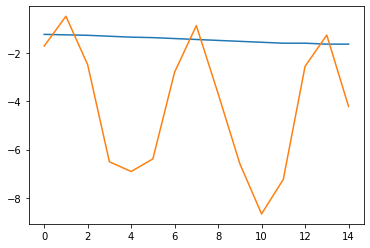

In [66]:
plt.plot(y_test[96:111,0])
plt.plot(μ)

In [43]:
np.array(μ[-1])[np.newaxis, np.newaxis, np.newaxis]

array([[[-5.35909823]]])

In [108]:
x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor(path_to_data="datasets/ETTm2.csv") 


In [48]:
dataset = "ETTm2"

if dataset == "exchange":
    x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor(path_to_data="datasets/ETTm2.csv") 
    save_dir = "weights/forecasting/exchange"
    print('make sure to create the exchange folder in weights/forecasting/')
else: 
    raise ValueError("Dataset not found")
    
save_dir = save_dir + "/" + model

    
batch_size = 32
test_batch_s = 100

nll_list = []
mse_list = []




ValueError: Dataset not found

In [50]:
save_dir = "weights/forecasting/ETT/atp"

In [157]:

run = 0
tr_step = atp_graph.build_graph()

###### can we put the name of the model into the folder name #########?

name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp
if not os.path.exists(folder): os.mkdir(folder)
opt = tf.keras.optimizers.Adam(3e-4)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 
sum_mse_tot = 0; sum_nll_tot = 0
mini = 50000

In [156]:
model = atp_pipeline.atp_pipeline(num_heads=6, projection_shape_for_head=11, output_shape=32, rate=0.05, permutation_repeats=0,
                 bound_std=False, num_layers=4, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")  

In [91]:

name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp

In [92]:
folder

'weights/forecasting/ETT/atp/ckpt/check_run_0'

In [103]:
ckpt = tf.train.Checkpoint(step=tf.Variable(37), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [102]:
model.weights

[<tf.Variable 'atp_pipeline_6/atp_6/mha_x_a_1/multi_head_attention_8/dense_338/kernel:0' shape=(34, 66) dtype=float32, numpy=
 array([[ 0.11518715, -0.11916751, -0.12097967, ..., -0.19219631,
         -0.14608407, -0.09943974],
        [-0.08130005,  0.09241389, -0.16797861, ...,  0.2002273 ,
         -0.20151228,  0.2001578 ],
        [-0.02594618, -0.15657733, -0.2403611 , ...,  0.23188491,
          0.11237641, -0.23858935],
        ...,
        [ 0.1861551 ,  0.2056062 ,  0.1100481 , ..., -0.1331253 ,
         -0.13363129, -0.22495413],
        [-0.23934188, -0.09776428,  0.15087406, ..., -0.12157541,
         -0.06403819, -0.15895727],
        [ 0.11731912, -0.17689319, -0.1039883 , ..., -0.07453471,
         -0.16259526, -0.03720199]], dtype=float32)>,
 <tf.Variable 'atp_pipeline_6/atp_6/mha_x_a_1/multi_head_attention_8/dense_338/bias:0' shape=(66,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.

In [104]:
# supposedly loaded model weights
model.weights

[<tf.Variable 'atp_pipeline_6/atp_6/mha_x_a_1/multi_head_attention_8/dense_338/kernel:0' shape=(34, 66) dtype=float32, numpy=
 array([[-0.1046595 ,  0.05602785, -0.0800577 , ...,  0.21868247,
         -0.11370457, -0.08860778],
        [-0.23481385, -0.11279382,  0.22716829, ..., -0.17256613,
          0.13343005,  0.05205701],
        [-0.20905007, -0.21812609, -0.1221335 , ..., -0.13785739,
          0.04353318, -0.03863214],
        ...,
        [-0.16908331,  0.14412396, -0.19961055, ..., -0.17885692,
         -0.26478288,  0.1731888 ],
        [-0.01271342,  0.01176838, -0.06046362, ..., -0.23999518,
          0.17027076,  0.0428196 ],
        [-0.10467955, -0.2353619 ,  0.06798597, ..., -0.03560879,
         -0.21382986, -0.08660617]], dtype=float32)>,
 <tf.Variable 'atp_pipeline_6/atp_6/mha_x_a_1/multi_head_attention_8/dense_338/bias:0' shape=(66,) dtype=float32, numpy=
 array([-0.03512219, -0.06235101, -0.00353969,  0.01841216,  0.0306075 ,
        -0.01460871,  0.02046598, -0.

In [79]:
for i in range(2000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    _,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not just forecasting
    x = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=32)
    #### edit batcher to fix this
    _,_, nll_pp_tr, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if (i + 1) % 100 == 0:
        train_array.append(nll_pp_tr)
        idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
        _,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=100)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        array.append(nll_pp_te)
        
        plt.plot(train_array)
        plt.plot(array)
        plt.show()

        print(nll_pp_te)
        print(min(array))

        if nll_pp_te < mini:
            mini = nll_pp_te
            manager.save()
            step += 1
            ckpt.step.assign_add(1)




TypeError: in user code:


    TypeError: tf__train_step() missing 1 required positional argument: 'training'


In [84]:
ckpt = tf.train.Checkpoint(step=tf.Variable(step), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [ ]:
test_batch_s = 100

sum_mse_tot = 0; sum_nll_tot = 0

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = len(idx_list)//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)        
    _,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=y_te.shape[0])
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)

print(msex)

## Gp

In [ ]:
i = 0
step = 1
run= 50 + i
tf.random.set_seed(run)


In [ ]:
n_C = 10
n_T = 40

Model 1 

model = atp_pipeline.atp_pipeline(num_heads=3, projection_shape_for_head=10, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=6, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage=True)

-0.61

Model 2

model = atp_pipeline.atp_pipeline(num_heads=3, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=5, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage=False)

-0.7

Model 3 

model = atp_pipeline.atp_pipeline(num_heads=10, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=6, enc_dim=32, xmin=0.1, xmax=2,MHAX_leakage="new_block")
                 
-0.87

Model 4 

model = atp_pipeline.atp_pipeline(num_heads=8, projection_shape_for_head=12, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=1,MHAX_leakage="xxx")

-1.0

In [ ]:
model = atp_pipeline.atp_pipeline(num_heads=10, projection_shape_for_head=9, output_shape=32, rate=0.0, permutation_repeats=0,
                 bound_std=False, num_layers=6, enc_dim=32, xmin=0.1, xmax=2,MHAX_leakage="new_block")
            
array = []
train_array = []

idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
x,y, = batcher_np(x_train,y_train)

μ, log_σ = model([x, y, n_C, n_T, False])


model.summary()

In [ ]:

    run = 5
    tr_step = atp_graph.build_graph()

    ###### can we put the name of the model into the folder name #########?

    name_comp = 'run_' + str(run)
    folder = save_dir + '/ckpt/check_' + name_comp
    if not os.path.exists(folder): os.mkdir(folder)
    opt = tf.keras.optimizers.Adam(3e-4)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
    ckpt.restore(manager.latest_checkpoint) 
    sum_mse_tot = 0; sum_nll_tot = 0
    mini = 50000

In [ ]:
for i in range(4000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    x,y = batcher_np(x_train,y_train)
    _,_, nll_pp_tr, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        train_array.append(nll_pp_tr)
        t_te,y_te = batcher_np(x_val,y_val,batch_s = 100)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        array.append(nll_pp_te)
        
        plt.plot(train_array)
        plt.plot(array)
        plt.show()

        print(nll_pp_te)
        print(min(array))

        if nll_pp_te < mini:
            mini = nll_pp_te
            manager.save()
            step += 1
            ckpt.step.assign_add(1)


